---
layout: post
title: "Spotify Popularity Prediction Model"
excerpt: "Using song characteristics to predict popularity"
permalink: /Spotify/


---

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

import warnings

# Filter out future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
#Import Data

pd.set_option('display.max_rows', 10)
pd.options.display.max_columns = None


tracks=pd.read_csv('spotify_tracks.csv')

In [37]:
# Cleaning

tracks=tracks.dropna()
tracks['release_year'] = tracks['release_date'].str[:4]
tracks = tracks.query("release_year > '1900'")

In [38]:
#Prep Dummy Variables and Fix Data types
pd.to_numeric(tracks['release_year'])
tracks['mode']=tracks['mode'].astype(str)
tracks['key']=tracks['key'].astype(str)
tracks['time_signature']=tracks['time_signature'].astype(str)
tracks['explicit']=tracks['explicit'].astype(str)

In [39]:
#making target category
conditions=[
    (tracks['popularity'] <= 29),
    (tracks['popularity'] >= 30) & (tracks['popularity'] <= 59),
    (tracks['popularity'] >= 60) & (tracks['popularity'] <= 100)]

# create a list of the values we want to assign for each condition
values = [ 'low_pop', 'med_pop', 'high_pop']

# create a new column and use np.select to assign values to it using our lists as arguments
tracks['pop_tier'] = np.select(conditions, values)

Whether music listeners are aware of it or not, much of their music taste is shaped by the algorithms used by streaming services. This sometimes controversial truth, as highlighted in a [Guardian article](https://www.theguardian.com/music/2018/oct/05/10-years-of-spotify-should-we-celebrate-or-despair), exemplifies the increasing dependence of entertainment streaming services and social media platforms on machine-learning processes to recommend content to users. Surprisingly insightful discoveries can be made by examining the features that these models utilize to better understand why some content appears to be more 'popular' than others.

For example, Spotify employs machine-learning algorithms to analyze audio data for each individual song and assign ratings to its sonic characteristics. These features are considered when assigning songs to auto-generated playlists or making recommendations to users based on sonic similarities to their listening history.

To gain a deeper understanding of these streaming recommendation algorithms, I aim to investigate trends in these sonic characteristics and explore how they correlate, if at all, with the popularity of a given song.

## Spotify Dataset

For this investigation, I utilized a dataset of 586,672 songs randomly selected from Spotify's song database. The dataset encompasses release years from 1922 to 2021. Each row of data includes features such as sonic characteristics, artist name, and song length. The target feature in this dataset is the "popularity" column, which represents a weighted measure of total streams where recent streams are assigned a higher weight.

I added an additional column that categorizes a song's popularity score into one of three classes based on the popularity score. The bin thresholds for the classification are illustrated in the following table:

| Class    | Popularity Score |
|----------|------------------|
| Low Pop  | 0-29             |
| Med Pop  | 30-59            |
| High Pop | 60-100           |


## Change in Average Song Features Over Time

This interactive graph displays the change in the yearly average of all songs released in a given year over time. Each feature has been scaled to ensure they are on the same scale for better comparison across different features.

This graph illustrates changes in characteristics across songs cataloged in Spotify's database over time.

**Capabilities of this dynamic plot:**

1. Filter which features to display via the legend.
2. Zoom in on a Time Slice by selecting via cursor.
3. Reset Zoom by clicking Autoscale in the top-right corner.

In [40]:
#Normalize the features

# Create a copy of the original DataFrame
normalized_tracks = tracks.copy()

# Define the list of features to normalize
normalized_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                       'instrumentalness', 'tempo', 'popularity', 'valence', 'duration_ms']

# Select the columns to normalize from the copied DataFrame
columns_to_normalize = normalized_tracks[normalized_features]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the selected columns
normalized_values = scaler.fit_transform(columns_to_normalize)

# Replace the original values with the normalized values in the copied DataFrame
normalized_tracks[normalized_features] = normalized_values

# Removing Key and Time Signiture
normalized_tracks.drop(columns=['key', 'time_signature','mode'], inplace=True)


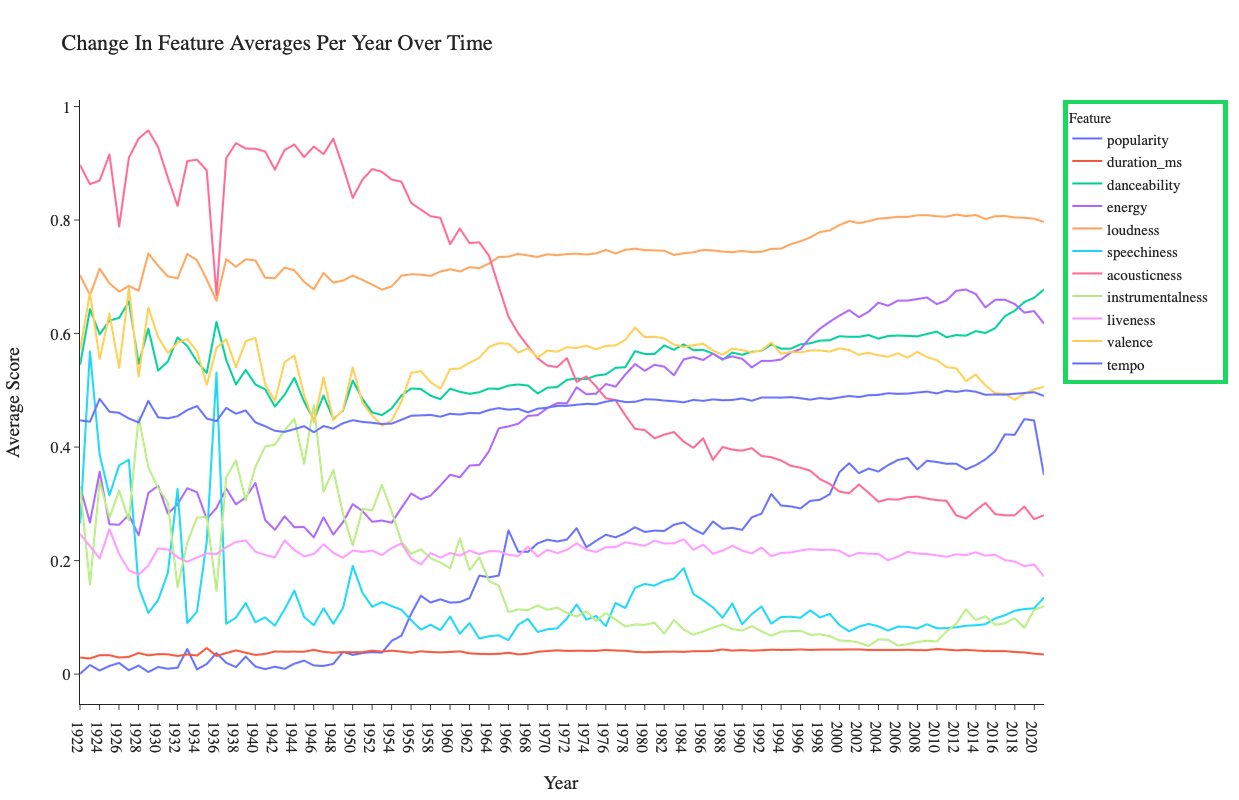

In [48]:
# Assign Averages for each Feature by Release Year

avg_features_by_year = normalized_tracks.groupby('release_year').mean().reset_index()

# Melt the DataFrame to long format for Plotly
avg_features_melted = avg_features_by_year.melt(id_vars='release_year', var_name='feature', value_name='average')

# Create an Line plot
fig = px.line(avg_features_melted, x='release_year', y='average', color='feature', line_group='feature',
              title='Change In Feature Averages Per Year Over Time',
              labels={'release_year': 'Year', 'average': 'Average Score', 'feature': 'Feature'})

# Formatting the Plot
fig.update_layout(
    height=800,
    font=dict(family='Open Sans", verdana, arial, sans-serif', size=16),  
    plot_bgcolor='#ffffff',  
    template="simple_white",
    xaxis=dict(showgrid=False), 
    yaxis=dict(showgrid=False, gridcolor='#1db954'),  
    legend=dict(  # Customize legend
        title='Feature',
        title_font=dict(size=14),
        font=dict(size=15),
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='#1ed760',
        borderwidth=4
    )
)

# Show the plot
fig.show()


## Trends of Interest

- Examining the 2001-2021 timeframe, the most notable increases are observed in Explicit content (83%) and Danceability (12%).

- Loudness and Energy have exhibited gradual growth since the mid-1950s.

- Acousticness experienced a sharp decline in the early 1960s, coinciding with the onset of the [British Invasion](https://www.rollingstone.com/feature/the-british-invasion-from-the-beatles-to-the-stones-the-sixties-belonged-to-britain-244870/), which introduced Electric Rock 'n' Roll to mainstream popular culture on an international scale.

- **A key takeaway is that average sonic characteristics have evolved over the decades. This evolution will impact how the algorithm predicts a song's popularity, particularly if it relies solely on sonic features while disregarding factors such as Release Year and Artist.**

## Sonic Characteristic Correlation Heatmap

This Heatmap shows the relationship of sonic features with the popularity of a song. 

### Notable insights:

### (+)  Postive relationship: Danceability, Energy, and Loudness

### (-)  Negative relationship: Acousticness, Instrumentalness, and Duration

<Axes: >

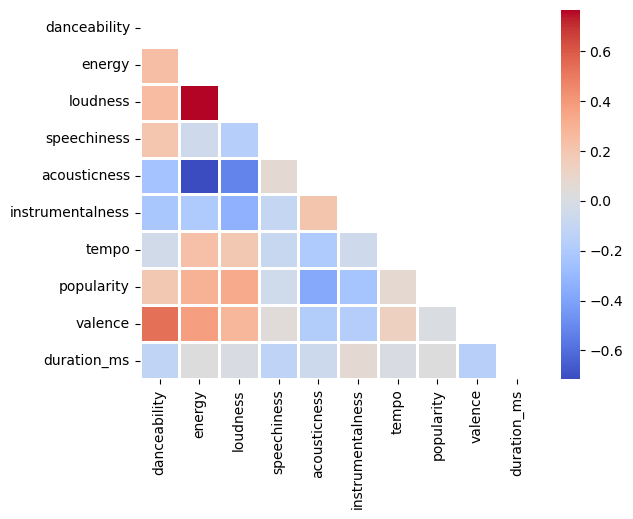

In [42]:
columns_to_plot = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                   'instrumentalness', 'tempo', 'popularity', 'valence','duration_ms']
matrix = tracks[columns_to_plot].corr()
mask = np.triu(np.ones_like(matrix.corr()))
sns.heatmap(matrix, cmap='coolwarm' , annot = False, mask=mask, linewidths=2)     

## What We've Learned So Far and Release Year Adjustments

After gaining a better understanding of how song features have evolved over time, it's not surprising to see that the features experiencing the most growth also exhibit the strongest positive relationship with song popularity (e.g., Danceability and Loudness), as depicted in the Heatmap.

The popularity score, which favors more recent streams, tends to be biased toward the average characteristics of recent songs. We have observed that these characteristics differ, on average, from songs released in prior periods. To mitigate this bias, we will subset the dataset to include only recently released songs. This will provide a more unbiased training set for the algorithm to use when predicting popularity based on song characteristics.

### **To address this bias going forward, only songs released since 2019 will be included in the analysis and model training.**

# Building a Predictive Model

With a better understanding of the characteristics associated with popular songs, we can attempt to build a predictive model that emulates the algorithm Spotify uses to predict whether a song will be popular among listeners based on sonic characteristics alone.

The Random Forest algorithm is the best choice for a predictive model in this context. Random Forest models are resistant to overfitting, which is important for a scalable model that would be used across Spotify's massive database of tracks, exceeding 100 million. Additionally, Random Forest has strong capabilities to capture complex and non-linear relationships, while also resisting outliers and noisy data present in this dataset, such as the non-music white noise tracks, for example.

This model will be trained on 75% of the data and then validated using the remaining 25%.

### The output of the initial Random Forest model had the following accuracy for predicting the popularity class:

| Input Data | Accuracy     |
|------------------|----------------|
| Training          | 99.23%           |
| Testing          | 65.56%        |



The test accuracy score demonstrates how the model performs on data it has never seen before. A score of 65.56% shows that model has a moderate abilty to correctly assign songs a popularity class. 


## Class Balancing 

Classification algorithms can develop a bias towards a given class based on its volume in the data. If a certain group is not adequately represented in the training data, the model will be less likely to recognize characteristics of that group when analyzing new data. Consequently, the model may incorrectly assign inputs to a class that is more abundantly represented in the training data due to the bias of being more familiar with the dominant class.

The dataset used for building this model has the following counts for each Popularity Class:

| Popularity Class | Count     |
|------------------|----------------|
| Low Pop          | 8155           |
| Med Pop          | 15362          |
| High Pop         | 8608         |

The disproportionate volume across each class could potentially lead to bias in the model. Therefore, addressing class imbalance is essential to ensure the model's performance across all classes.

I'll use a technique called recall score that measure the models accuarcy for predicting each individual class, rather than on calcuating the total accuracy. This following is the output of running this validation process: 

| Popularity Class | Recall Score     |
|------------------|----------------|
| Low Pop          | 0.7024           |
| Med Pop          | 0.8581        |
| High Pop         | 0.2455        |

This tendency to be incorrect when predicting Low Pop and High Pop could be attributed to their underrepresentation compared to Med Pop. The inaccuracy in predicting the High Pop classification could pose a significant issue for real-life implementation models. This is because the ability to recognize and recommend songs with high popularity potential would be a key feature of Spotify's algorithm. Therefore, addressing the imbalance in class representation is crucial for improving the model's accuracy, especially in predicting less-represented classes like Low Pop and High Pop.

### Oversampling via SMOTE

I can artificially balance the volume of each category using the oversampling technique Synthetic Minority Over-sampling TEchnique (SMOTE). Unlike random oversampling, SMOTE generates synthetic data rows rather than oversampling by duplicating rows in the class.

This approach may enhance the model's ability to recognize songs with High Pop potential based on sonic characteristics by providing more representative samples of the minority classes.

After balancing the classes using the SMOTE process, it appears that the model's overall accuracy score decreased to 64.05%, a decrease of 1.01% from the non-class-balanced score. However, despite the decrease in overall accuracy, the model demonstrated improved capability in properly assigning the underrepresented classes. The most significant increase was observed in the High Pop category, which, as mentioned earlier, is a key use case for this predictive model.

The table below displays both balanced and unbalanced recall scores and the percentage change:

| Pop Class | Unbalanced Test Recall | Balanced Test Recall     |     % Change     |
|---|------------------|----------------|---------|
|Low Pop| 70.24%          | 73.22%           |  + 4%  |
|Med Pop| 85.81%          | 76.37%          |  - 11%  |
|High Pop| 24.55%         | 33.91%         |    + 38%  |

# Accurately Predicting Song Popularity is Complex

Spotify's algorithm for evaluating the potential popularity of a track extends beyond the features utilized in training my predictive model. While my model provides valuable insights into how various sonic characteristics correlate with popularity, Spotify's algorithm includes additional factors such as user listening history, social trends, and is strongly influenced by artist and label marketing strategies. 

A more accurate understanding of predicting track popularity necessitates a comprehensive approach that considers not only musical features but also broader contextual elements and streaming analytics. Moving forward, further exploration and refinement of my model could involve incorporating additional data sources related to playlisting and user behviors to better understand what makes song stand out amoung the 100 million+ tracks available on the platfrom.

---


For those interested in recreating or extending this analysis, you can access the code in a Jupyter Notebook [here]().